In [1]:
import warnings, requests, re, sqlite3, tqdm, json, pandas as pd, matplotlib.pyplot as plt, numpy as np
warnings.filterwarnings("ignore", category=FutureWarning) 


#collect assets supply
policy="""f96584c4fcd13cd1702c9be683400072dd1aac853431c99037a3ab1e"""
supply=10_000
royalities = 0.07 + 0.02
df = pd.DataFrame()

print("""collecting assets""")
for no in tqdm.tqdm(range(0, int(supply/50))):
    r = requests.get(f"""https://cardanoscan.io/tokens?pageNo={str(no)}&policyId={policy}""")
    html = r.content.decode('utf-8')
    df = df.append(pd.DataFrame(re.findall("""<a href=/token/f96584c4fcd13cd1702c9be683400072dd1aac853431c99037a3ab1e([^>]+)>([^<]+).*?asset([^>]+)>.*?trxTimestamp>([^<]+)<""", html), columns=['assetid','name', 'fingerprint', 'createtime']))
    #print(str(no*50), end='\r')
    
    if """>NO MORE TOKENS<""" in html:
        break;

df = df.drop_duplicates()
print(f"""{len(df)} Assets found""")




# this is inaccurate but close enough and fast
print("""add mint prices""")
def minting(x):
    if x < 1000:
        return 52
    elif x < 2000:
        return 62
    elif x < 3000:
        return 72
    elif x < 4000:
        return 82
    elif x < 5000:
        return 92
    else:
        return 100
    

temp = df.sort_values('createtime').reset_index(drop=True).reset_index()
temp['mint'] = temp['index'].apply(lambda x: minting(x) )
del temp['index']



#collect sales on jpg
print("""collecting sales""")
df_jpg=pd.DataFrame()

for page in tqdm.tqdm(range(1,99+1)):
    r = requests.get(f"""https://server.jpgstoreapis.com/collection/{policy}/transactions?page={page}&count=100""")
    html = r.content.decode('utf-8')
    if """{"transactions":[],"tot":""" in html:
        break;
    df_jpg = df_jpg.append(pd.DataFrame(json.loads(html)['transactions']))
    df_jpg = df_jpg.drop_duplicates()
    #print(str(page), end='\r')
print(f"""collected {len(df_jpg)} sales""")


#merge data
print("""merging data""")
#only keep first sales of an asset
temp_j = df_jpg[['confirmed_at','amount_lovelace','asset_id']].drop_duplicates('asset_id', keep='last').copy()
temp_j.columns = ['jtime', 'sold','assetid']
temp_j['assetid'] = temp_j['assetid'].apply(lambda x: x.replace(policy,'')) 
full = pd.merge(temp, temp_j, on="assetid").drop_duplicates()
full['sold'] = full['sold'].apply(lambda x: x/1000000)
full['profit']=full['sold']*(1-royalities)-full['mint']

p = []
for r in [52, 62, 72, 82, 92, 100]:
    p.append(full[full['mint']==r]['profit'].sum())
    
    
d = {}

for r in [50, 60, 70, 80, 90, 100, 101, 10000]:
    d[r] = full[full['sold']<=r]['mint'].value_counts()

dd = pd.DataFrame(d)

dd[101] = dd[10000] - dd[100]
dd[100] = dd[100] - dd[90]
dd[90] = dd[90] - dd[80]
dd[80] = dd[80] - dd[70]
dd[70] = dd[70] - dd[60]
dd[60] = dd[60] - dd[50]


dd.columns = ['<50', '50-60', '60-70', '70-80', '80-90','90-100','100+','total']
dd['profit'] = p


dd['avg_profit'] = dd['profit']/dd['total']
dd['avg_profit'] = dd['avg_profit'].apply(lambda x: int(x*100)/100 )
ff= dd.reset_index().copy()
ff.columns = ['mint', '<50', '51-60', '61-70', '71-80', '81-90', '91-100', '101+',
       'total', 'profit', 'avg_profit']

ff

collecting assets


 62%|██████▏   | 124/200 [01:06<00:41,  1.85it/s]


6129 Assets found
add mint prices
collecting sales


 20%|██        | 20/99 [00:23<01:34,  1.20s/it]

collected 1999 sales
merging data


,mint,<50,51-60,61-70,71-80,81-90,91-100,101+,total,profit,avg_profit
0,52,34,87,124,72,32,19,58,426,17584.06,41.27
1,62,63,58,98,59,23,30,51,382,11537.55,30.20
2,72,42,45,35,17,16,12,43,210,8167.81,38.89
3,82,48,70,53,28,13,17,54,283,6791.24,23.99
4,92,59,43,81,32,11,15,49,290,-1620.42,-5.58
5,100,1,54,66,19,6,6,28,180,-2265.19,-12.58


## Directly sold mints

<AxesSubplot:xlabel='day'>

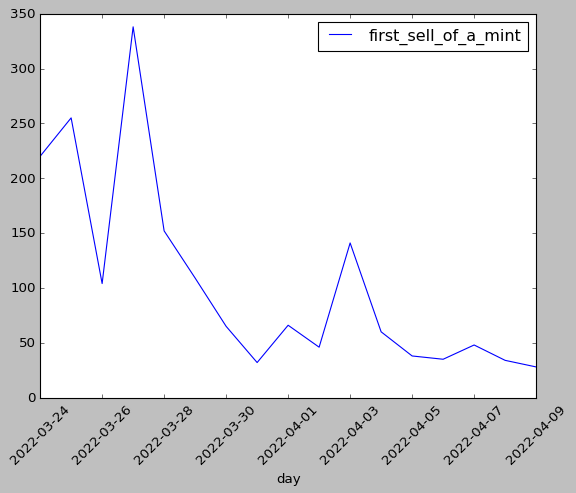

In [2]:
plt.style.use('classic')

full['day'] = full['jtime'].apply(lambda x: str(x).split('T')[0])
overtime = pd.DataFrame(sorted(list(full['day'].value_counts().items())), columns=['day','first_sell_of_a_mint'])
overtime.index=overtime['day']
del overtime['day']
overtime.plot(rot=45)

## Get Addresses of Minters

In [3]:
#trxhash

print('get tminting addresses')
mint_df = pd.DataFrame()
for asset in tqdm.tqdm(df['assetid']):
    r = requests.get(f"""https://cardanoscan.io/token/{policy}{asset}""")
    html = r.content.decode('utf-8')
    temp = re.findall("""transaction/([^>]+)[?]tab=tokenmint.*?/block/([0-9]+).*?/epoch/([0-9]+)""",html)
    
    trx = temp[0][0]
    r = requests.get(f"""https://cardanoscan.io/transaction/{trx}""")
    html = r.content.decode('utf-8')
    addr = html.split(f"""{policy}{asset}""")[0].split('addressField')[-1].split('address/')[-1].split('>')[0]
    
    mint_df = mint_df.append(pd.DataFrame([(asset,)+temp[0]+(addr,)], columns = ["asset","trxhash", "block", "epoch", "addr"]))
    
mint_df

get tminting addresses


100%|█████████████████████████████████████| 6079/6079 [1:54:07<00:00,  1.13s/it]


,asset,trxhash,block,epoch,addr
0,50697070614d6349766572,7d5abdc56d1d8c45a736f04915ceef82cf38d24cb88255...,7098928,331,addr1q9lnk4jhjasdyetd78h6r5dp02kmsqt7zhzqf46xj...
0,4d72436173657943617374726f,7d5abdc56d1d8c45a736f04915ceef82cf38d24cb88255...,7098928,331,addr1q9lnk4jhjasdyetd78h6r5dp02kmsqt7zhzqf46xj...
0,4b696b69426967676c6573776f727468,7d5abdc56d1d8c45a736f04915ceef82cf38d24cb88255...,7098928,331,addr1q9lnk4jhjasdyetd78h6r5dp02kmsqt7zhzqf46xj...
0,436f636f4d6163496e6e6973,7d5abdc56d1d8c45a736f04915ceef82cf38d24cb88255...,7098928,331,addr1q9lnk4jhjasdyetd78h6r5dp02kmsqt7zhzqf46xj...
0,43686169726d616e576f6a61636b4b6c65696e,7d5abdc56d1d8c45a736f04915ceef82cf38d24cb88255...,7098928,331,addr1q9lnk4jhjasdyetd78h6r5dp02kmsqt7zhzqf46xj...
...,...,...,...,...,...
0,417567757374696e654d63476565,f87bb4958c4154f0e9ea176042894f36aab2671f23ebc1...,7078165,330,addr1vxjnhc4rgzk5g53f0num5vcj6qn0zzgcvjucyytd2...
0,4c696c4d69737345646e6153756d6d657273,da081b505418e27e89f8339afca3b17110e83905794c5b...,7083816,330,addr1vxjnhc4rgzk5g53f0num5vcj6qn0zzgcvjucyytd2...
0,4e6f6f646c6549646f6c,da081b505418e27e89f8339afca3b17110e83905794c5b...,7083816,330,addr1vxjnhc4rgzk5g53f0num5vcj6qn0zzgcvjucyytd2...
0,5369724a6f654861726479,da081b505418e27e89f8339afca3b17110e83905794c5b...,7083816,330,addr1vxjnhc4rgzk5g53f0num5vcj6qn0zzgcvjucyytd2...


In [4]:
con = sqlite3.connect("pcs.db")
df.to_sql("mintsale1", con, if_exists="append", index=False)
ff.to_sql("mintsale2", con, if_exists="append", index=False)
full.to_sql("mintsale3", con, if_exists="append", index=False)
mint_df.to_sql("mintsale4", con, if_exists="append", index=False)

In [9]:
db = sqlite3.connect('pcs.db')
query = db.execute("SELECT * From mintsale3")
cols = [column[0] for column in query.description]
assets= pd.DataFrame.from_records(data = query.fetchall(), columns = ['asset']+cols[1:])

query = db.execute("SELECT * From mintsale4")
cols = [column[0] for column in query.description]
mints= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)

fulldata = pd.merge(assets, mints, on="asset")

In [10]:
fulldata

,asset,name,fingerprint,createtime,mint,jtime,sold,profit,day,trxhash,block,epoch,addr
0,526f73616e6e6550696e6b6d616e,RosannePinkman,1s0tvs0t3uzrw05l635hcfd44mtturmx6gc06zw,1648136306000,52,2022-03-27T15:13:02.512+00:00,50.0,-6.50,2022-03-27,77c29e5d7bdf9199daa5e4d2587e3adbd2e2b9f91956d8...,7036861,328,addr1qxf2jvx5aj88a0x62c3pf47pm2m264w6wej98ctlu...
1,5065616e75744b6f7a6c6f76,PeanutKozlov,1dra7ajgrhngtuxzzg6v9ck9sgur2hgeezj2kwd,1648136306000,52,2022-03-24T17:30:07.434+00:00,60.0,2.60,2022-03-24,77c29e5d7bdf9199daa5e4d2587e3adbd2e2b9f91956d8...,7036861,328,addr1qxf2jvx5aj88a0x62c3pf47pm2m264w6wej98ctlu...
2,4c7563696c6c654a6566666572736f6e,LucilleJefferson,1z8em493xgswdappq9cfhvlrnv2mypydx6dluzx,1648136495000,52,2022-03-24T18:03:26+00:00,80.0,20.80,2022-03-24,f376851af72392406af4febf9be29a663378ff46e01577...,7036868,328,addr1q8rlqxwxel78kvav55enuyme4ke89nnzdhvnd3vs4...
3,4f6c69766572436c61726b,OliverClark,1j6kn6wgw6nnrquctrvwq8f5z9j7msswest302r,1648136495000,52,2022-03-28T15:31:05.219+00:00,200.0,130.00,2022-03-28,f376851af72392406af4febf9be29a663378ff46e01577...,7036868,328,addr1q8rlqxwxel78kvav55enuyme4ke89nnzdhvnd3vs4...
4,4f72656f46656465726f76,OreoFederov,1wtgu8w6lqveandlwgf5su57ptu42p8r65c7de8,1648136495000,52,2022-03-25T06:28:58+00:00,160.0,93.60,2022-03-25,f376851af72392406af4febf9be29a663378ff46e01577...,7036868,328,addr1q8rlqxwxel78kvav55enuyme4ke89nnzdhvnd3vs4...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,416d656c6961536177796572,AmeliaSawyer,1vddf7k4vl8ef4haerjfar80r47x30lc7vr8ttu,1649290508000,100,2022-04-07T14:29:05.078+00:00,60.0,-45.40,2022-04-07,9931949d97ede55b4cfa08a41ce6e5c421b98a6e9ade8f...,7091857,331,addr1q9rrfvvtgxk9nf4z9l99nrpmk77c5pe8qjy06ks8c...
1764,416c65784d7572706879,AlexMurphy,1k6ejjeqgsy9uaxtj7724qhs0y2fm65vqdnrehv,1649311808000,100,2022-04-09T16:38:04.090+00:00,60.0,-45.40,2022-04-09,159ef116daac8674a35c385a27f87d5c4c5c5daa673605...,7092879,331,addr1qy9ap7ukj0tfz8uqlr9gym53ukqmau4fl9tpyt7cc...
1765,536d6f6b65795061706167656f7267696f,SmokeyPapageorgio,1qdstzxdq7ufkyzkze524jpfy54cnvhkpf9krdg,1649312108000,100,2022-04-07T22:32:05.319+00:00,60.0,-45.40,2022-04-07,dad9818d98d1b098e75584d608e453ddca8d2e5f390f13...,7092896,331,addr1qy9ap7ukj0tfz8uqlr9gym53ukqmau4fl9tpyt7cc...
1766,48657263756c65734f74746f,HerculesOtto,1t2rh987sv3u70kaes2k0vld05axcwqp58zcdag,1649340917000,100,2022-04-08T21:19:04.064+00:00,60.0,-45.40,2022-04-08,1721ff4b17ada7738ee9edda74868ee53ba3d28f4610c8...,7094238,331,addr1q9rrfvvtgxk9nf4z9l99nrpmk77c5pe8qjy06ks8c...


In [11]:
fulldata['addr'].value_counts()

addr1q95ylmv9h7rz9v0vyg9zldqd9hxktq4mgu6slhv0g9y5r97tkv8ujvex8v04h9x6nc92xtjy2ayxfgk0n25h3vm94kwsv2wp9m    90
addr1q8jytnpfarfxx2tuqus7qs9t8vu6py5nealah6rrvjgwaa5zhpjr5txf0uflpuals9cwrv54fptjmk72074wresk7plqdwueg6    39
addr1vxjnhc4rgzk5g53f0num5vcj6qn0zzgcvjucyytd2ahsmrgrkdn24                                                 25
addr1q99ckz3tn0unenjeskjwqcefhpw9nwldtzytpuq6rh0sjspa7cnz4srnlt3aknra2t4z9cc6gxjzmxhtj2zm2cjqdqvsgyztef    23
addr1q8ac7c59wv89cl28u000cmap296j8dukxjf4au4e5qvry8hkxzq9fp4l8uwrwxntl7ueap7e2q9gre4x9f8rfjejd9ps3jdfpl    22
                                                                                                           ..
addr1q99y08wzquta0pcny9f8xxxy0cstuqqkgjmqkvfqdj9xkcpj2c2awtpkg0jz4heaukdavxqt8uvym24ku3c90q050ezqlm3qj8     1
addr1qxaenxcvjuwm75tew89grgsaaq55fvx9k8pssk9s8q34jqlmvhkd0vexxw6r78ps0937mh842t65enmqepy2c2ul92pq0h5xqw     1
addr1q97f488d69lyf8j3z6733j8wwz0rpd8zlcws222l4e5amqyqr8skmzyc4le5hmmke4xmd2f796ntw4ql6m9w4ljak9as0vclgh     1
addr1q9qvj